In [1]:
import geopandas as gpd
df = gpd.read_file('/data/acker/ALA/paper2/all_variables.shp')
df = df.rename(columns={'monitor__1':'monitor_coverage_pct', 'classifica':'classification', 'Design Val':'Design Value', 'monitor_co':'monitor_count',
                        'fire_regio':'fire_region', 'mountain_r':'mountain_region', 'desert_reg':'desert_region', 'urban_cate':'urban_category'})
#upload shapefile of U.S. counties
counties = gpd.read_file('/data/acker/shapefiles/cb_2020_us_county_500k.shp')
# List of state abbreviations for CONUS, Alaska (AK), and Hawaii (HI)
states_to_include = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'DC',
    'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS',
    'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK',
    'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV',
    'WI', 'WY'
]

# Filter counties to only include rows where STUSPS is in the specified list
counties_conus = counties[counties['STUSPS'].isin(states_to_include)]

# Display the filtered counties
counties_conus = counties_conus.drop(["COUNTYNS", 'NAMELSAD', 'LSAD', 'ALAND', 'AWATER', 'AFFGEOID'], axis=1)
counties_conus = counties_conus.to_crs(df.crs)
df = df.drop(columns='geometry')


# Merge with both GEOID and geometry
new = df.merge(counties_conus[['GEOID', 'geometry']], on='GEOID', how='inner')

# Recast as GeoDataFrame
ranked_correct = gpd.GeoDataFrame(new, geometry='geometry', crs=counties_conus.crs)
df = ranked_correct
df

,GEOID,PM25_90th,Design Value,classification,diff,abs_diff,monitor_count,cdv_bin,monitor_coverage_pct,dist_km,fire_region,mountain_region,desert_region,urban_category,geometry
0,02090,14.333333,12.1,TP,2.233333,2.233333,3,>10,0.008092,85.118385,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-148.66326 64.59079, -148.64821 64.5..."
1,06063,14.200000,14.0,TP,0.200000,0.200000,1,>10,0.013591,60.606568,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-121.49703 40.43702, -121.49487 40.4..."
2,06107,12.933334,15.7,TP,-2.766666,2.766666,1,>10,0.007784,100.833209,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-119.56647 36.49434, -119.56366 36.4..."
3,06023,12.633334,6.9,FN,5.733334,5.733334,1,<7,0.009894,28.714886,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-124.4086 40.4432, -124.39664 40.462..."
4,06029,12.599999,16.2,TP,-3.600001,3.600001,5,>10,0.023405,82.031806,Fire,Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-120.19437 35.78936, -120.00308 35.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,02020,4.133333,5.1,TN,-0.966667,0.966667,1,<7,0.020235,66.108117,Non-Fire,Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-150.07348 61.15834, -150.0691..."
532,02110,3.900000,4.6,TN,-0.700000,0.700000,1,<7,0.018594,73.544905,Non-Fire,Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-134.66932 58.33327, -134.6675..."
533,15001,3.633333,4.4,TN,-0.766667,0.766667,5,<7,0.054825,81.864071,Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"POLYGON ((-156.06147 19.72813, -156.06076 19.7..."
534,15009,3.556667,4.0,TN,-0.443333,0.443333,1,<7,0.035920,78.820617,Fire,Non-Mountain,Non-Desert,Non-Urban (<50%),"MULTIPOLYGON (((-156.69742 20.91637, -156.6957..."


In [2]:
disagreement = df


In [4]:
import geopandas as gpd


# Initialize
variables = []
delta_values = []

# Monitor Count
delta_monitor = abs(
    disagreement[disagreement['monitor_count'] <= 2]['abs_diff'].mean() -
    disagreement[disagreement['monitor_count'] > 2]['abs_diff'].mean()
)
variables.append('monitor_count')
delta_values.append(delta_monitor)

# CDV Bin
delta_cdv_bin = abs(
    disagreement[disagreement['cdv_bin'].isin(['<7', '>10'])]['abs_diff'].mean() -
    disagreement[disagreement['cdv_bin'] == '7–10']['abs_diff'].mean()
)
variables.append('cdv_bin')
delta_values.append(delta_cdv_bin)

# Monitor Coverage
delta_monitor_coverage = abs(
    disagreement[(disagreement['monitor_coverage_pct'] < 0.05) | (disagreement['monitor_coverage_pct'] > 0.1)]['abs_diff'].mean() -
    disagreement[(disagreement['monitor_coverage_pct'] >= 0.05) & (disagreement['monitor_coverage_pct'] <= 0.1)]['abs_diff'].mean()
)
variables.append('monitor_coverage_pct')
delta_values.append(delta_monitor_coverage)

# Fire Region
delta_fire = abs(
    disagreement[disagreement['fire_region'] == 'Fire']['abs_diff'].mean() -
    disagreement[disagreement['fire_region'] == 'Non-Fire']['abs_diff'].mean()
)
variables.append('fire_region')
delta_values.append(delta_fire)

# Mountain Region
delta_mountain = abs(
    disagreement[disagreement['mountain_region'] == 'Mountain']['abs_diff'].mean() -
    disagreement[disagreement['mountain_region'] == 'Non-Mountain']['abs_diff'].mean()
)
variables.append('mountain_region')
delta_values.append(delta_mountain)

# Desert Region
delta_desert = abs(
    disagreement[disagreement['desert_region'] == 'Desert']['abs_diff'].mean() -
    disagreement[disagreement['desert_region'] == 'Non-Desert']['abs_diff'].mean()
)
variables.append('desert_region')
delta_values.append(delta_desert)

# Urban Category
delta_urban = abs(
    disagreement[disagreement['urban_category'] == 'Non-Urban (<50%)']['abs_diff'].mean() -
    disagreement[disagreement['urban_category'] == 'Urban (≥50%)']['abs_diff'].mean()
)
variables.append('urban_category')
delta_values.append(delta_urban)

# Normalize weights
total_delta = sum(delta_values)
weights_A = {var: delta / total_delta for var, delta in zip(variables, delta_values)}

print("Option A: Weights (proportional to Δabs_diff)")
for var, weight in weights_A.items():
    print(f"{var}: {weight:.3f}")


Option A: Weights (proportional to Δabs_diff)
monitor_count: 0.072
cdv_bin: 0.210
monitor_coverage_pct: 0.117
fire_region: 0.158
mountain_region: 0.035
desert_region: 0.376
urban_category: 0.032


In [5]:
# Initialize
weighted_deltas = []

for var, delta in zip(variables, delta_values):
    if var == 'monitor_count':
        n_high_risk = disagreement[disagreement['monitor_count'] <= 2].shape[0]
    elif var == 'cdv_bin':
        n_high_risk = disagreement[disagreement['cdv_bin'].isin(['<7', '>10'])].shape[0]
    elif var == 'monitor_coverage_pct':
        n_high_risk = disagreement[(disagreement['monitor_coverage_pct'] < 0.05) | (disagreement['monitor_coverage_pct'] > 0.1)].shape[0]
    elif var == 'fire_region':
        n_high_risk = disagreement[disagreement['fire_region'] == 'Fire'].shape[0]
    elif var == 'mountain_region':
        n_high_risk = disagreement[disagreement['mountain_region'] == 'Mountain'].shape[0]
    elif var == 'desert_region':
        n_high_risk = disagreement[disagreement['desert_region'] == 'Desert'].shape[0]
    elif var == 'urban_category':
        n_high_risk = disagreement[disagreement['urban_category'] == 'Non-Urban (<50%)'].shape[0]
    
    weighted_delta = delta * n_high_risk
    weighted_deltas.append(weighted_delta)

# Normalize weights
total_weighted_delta = sum(weighted_deltas)
weights_C = {var: wd / total_weighted_delta for var, wd in zip(variables, weighted_deltas)}

print("\nOption C: Weights (Δabs_diff × prevalence)")
for var, weight in weights_C.items():
    print(f"{var}: {weight:.3f}")



Option C: Weights (Δabs_diff × prevalence)
monitor_count: 0.213
cdv_bin: 0.229
monitor_coverage_pct: 0.247
fire_region: 0.135
mountain_region: 0.051
desert_region: 0.032
urban_category: 0.092


In [6]:
# --- Calculate risk scores for monitored counties using Option C weights ---

# Apply Option C weights (assumes weights_A is already calculated)
risk_scores = []

for idx, row in df.iterrows():
    score = 0
    # Apply weights for each variable
    if row['monitor_count'] <= 2:
        score += weights_A['monitor_count']
    if row['cdv_bin'] in ['<7', '>10']:
        score += weights_A['cdv_bin']
    if (row['monitor_coverage_pct'] < 0.05) or (row['monitor_coverage_pct'] > 0.1):
        score += weights_A['monitor_coverage_pct']
    if row['fire_region'] == 'Fire':
        score += weights_A['fire_region']
    if row['mountain_region'] == 'Mountain':
        score += weights_A['mountain_region']
    if row['desert_region'] == 'Desert':
        score += weights_A['desert_region']
    if row['urban_category'] == 'Non-Urban (<50%)':
        score += weights_A['urban_category']
    
    risk_scores.append(score)

# Add risk scores to the dataframe
df['risk_score_A'] = risk_scores

# Normalize risk scores to 0-1 scale for easy comparison
df['risk_score_A_norm'] = (df['risk_score_A'] - df['risk_score_A'].min()) / (df['risk_score_A'].max() - df['risk_score_A'].min())

# Save output (optional)
# df.to_file('/data/acker/ALA/paper2/monitored_counties_with_risk.shp')

print(df[['GEOID', 'risk_score_A', 'risk_score_A_norm']].head(20))


    GEOID  risk_score_A  risk_score_A_norm
0   02090      0.551937           0.539875
1   06063      0.624387           0.620589
2   06107      0.624387           0.620589
3   06023      0.624387           0.620589
4   06029      0.551937           0.539875
5   06037      0.399908           0.370504
6   06031      0.349704           0.314574
7   06059      0.399346           0.369878
8   06019      0.551937           0.539875
9   06093      0.624387           0.620589
10  06047      0.466684           0.444898
11  06073      0.682586           0.685426
12  06025      0.964951           1.000000
13  06065      0.892501           0.919286
14  18097      0.326896           0.289164
15  48201      0.326896           0.289164
16  28047      0.262442           0.217358
17  41039      0.551937           0.539875
18  06039      0.624387           0.620589
19  26163      0.326896           0.289164


In [7]:
# --- Calculate risk scores for monitored counties using Option C weights ---

# Apply Option C weights (assumes weights_C is already calculated)
risk_scores = []

for idx, row in df.iterrows():
    score = 0
    # Apply weights for each variable
    if row['monitor_count'] <= 2:
        score += weights_C['monitor_count']
    if row['cdv_bin'] in ['<7', '>10']:
        score += weights_C['cdv_bin']
    if (row['monitor_coverage_pct'] < 0.05) or (row['monitor_coverage_pct'] > 0.1):
        score += weights_C['monitor_coverage_pct']
    if row['fire_region'] == 'Fire':
        score += weights_C['fire_region']
    if row['mountain_region'] == 'Mountain':
        score += weights_C['mountain_region']
    if row['desert_region'] == 'Desert':
        score += weights_C['desert_region']
    if row['urban_category'] == 'Non-Urban (<50%)':
        score += weights_C['urban_category']
    
    risk_scores.append(score)

# Add risk scores to the dataframe
df['risk_score_C'] = risk_scores

# Normalize risk scores to 0-1 scale for easy comparison
df['risk_score_C_norm'] = (df['risk_score_C'] - df['risk_score_C'].min()) / (df['risk_score_C'].max() - df['risk_score_C'].min())

# Save output (optional)
# df.to_file('/data/acker/ALA/paper2/monitored_counties_with_risk.shp')

print(df[['GEOID', 'risk_score_C', 'risk_score_C_norm']].head(20))


    GEOID  risk_score_C  risk_score_C_norm
0   02090      0.754502           0.741409
1   06063      0.967578           1.000000
2   06107      0.967578           1.000000
3   06023      0.967578           1.000000
4   06029      0.754502           0.741409
5   06037      0.456615           0.379890
6   06031      0.585751           0.536611
7   06059      0.688831           0.661710
8   06019      0.754502           0.741409
9   06093      0.967578           1.000000
10  06047      0.832422           0.835974
11  06073      0.506625           0.440582
12  06025      0.948785           0.977193
13  06065      0.735709           0.718602
14  18097      0.475756           0.403119
15  48201      0.475756           0.403119
16  28047      0.440606           0.360461
17  41039      0.754502           0.741409
18  06039      0.967578           1.000000
19  26163      0.475756           0.403119


In [8]:
df.columns

Index(['GEOID', 'PM25_90th', 'Design Value', 'classification', 'diff',
       'abs_diff', 'monitor_count', 'cdv_bin', 'monitor_coverage_pct',
       'dist_km', 'fire_region', 'mountain_region', 'desert_region',
       'urban_category', 'geometry', 'risk_score_A', 'risk_score_A_norm',
       'risk_score_C', 'risk_score_C_norm'],
      dtype='object')

In [9]:
# Extract the North Slope row from `counties_conus`
north_slope = counties_conus[counties_conus['GEOID'] == '02185'].copy()

# Set the `PM25_90th` column to None (or NaN) so it appears gray on the plot
north_slope['PM25_90th'] = None


/tmp/ipykernel_362180/1317266432.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


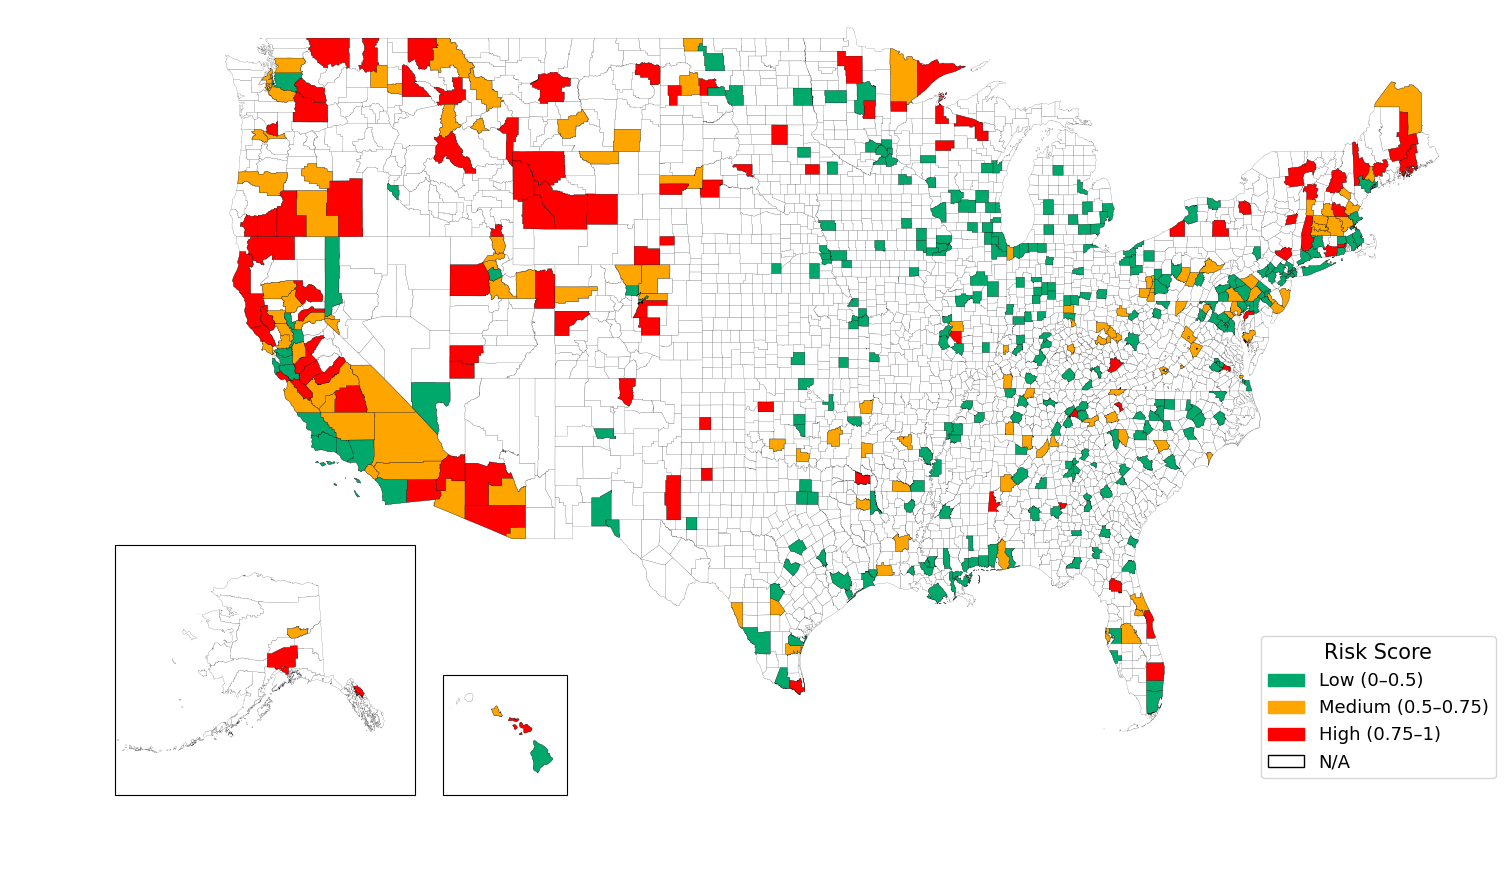

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd

# --- Load and prepare data ---
gdf_epa = df.to_crs("EPSG:4326")  # Make sure CRS is in lat/lon

# Use normalized risk scores
data_column = 'risk_score_C_norm'  # Change this if you saved under a different column name

# Define color mapping based on thresholds
def assign_risk_color(value):
    if pd.isna(value):
        return 'white'  # For missing values
    elif value <= 0.5:
        return '#00A86B'  # Low risk (green)
    elif value <= 0.75:
        return '#FFA500'  # Medium risk (orange)
    else:
        return '#FF0000'  # High risk (red)

# Apply color mapping
gdf_epa['color'] = gdf_epa[data_column].apply(assign_risk_color)

# --- Start plotting ---
fig = plt.figure(figsize=(15, 10))

# Main map (CONUS)
ax_conus = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_conus.set_extent([-135, -65, 20, 50], crs=ccrs.PlateCarree())
ax_conus.set_frame_on(False)

# Alaska inset
alaska_projection = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60)
ax_alaska = fig.add_axes([0.07, 0.14, 0.22, 0.25], projection=alaska_projection)
ax_alaska.set_extent([-180, -126, 50, 72], crs=ccrs.PlateCarree())

# Hawaii inset
ax_hawaii = fig.add_axes([0.28, 0.14, 0.12, 0.12], projection=ccrs.PlateCarree())
ax_hawaii.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

# Plot CONUS base map
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_conus
)

# Plot EPA counties on top
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)

# Plot Alaska and Hawaii base maps
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_hawaii
)

# Plot EPA counties for Alaska and Hawaii on top
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)


# --- Create custom legend ---
low_patch = mpatches.Patch(color='#00A86B', label='Low (0–0.5)')
medium_patch = mpatches.Patch(color='#FFA500', label='Medium (0.5–0.75)')
high_patch = mpatches.Patch(color='#FF0000', label='High (0.75–1)')
na_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="N/A")

plt.legend(
    handles=[low_patch, medium_patch, high_patch, na_patch],
    bbox_to_anchor=(6.5, 1.4), loc='upper left',
    title="Risk Score",
    fontsize=13,
    title_fontsize=15
)

# --- Title and layout ---
plt.rcParams["font.family"] = "serif"
#fig.suptitle("County Risk Assessment (Weighted Index)", fontsize=18, y=0.92)

plt.tight_layout()
plt.show()


/tmp/ipykernel_362180/1525941786.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


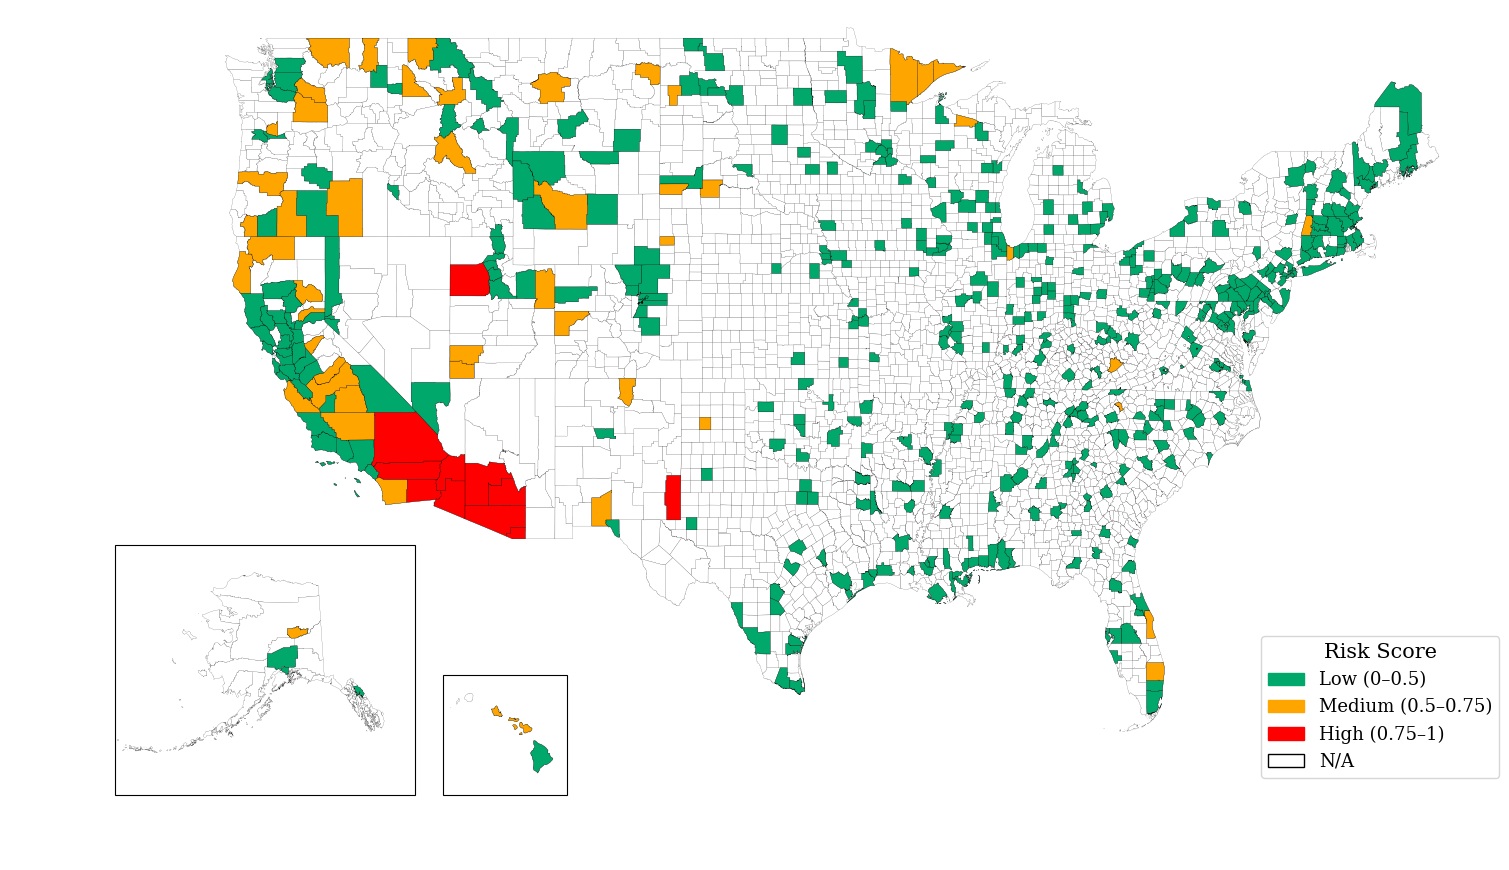

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.patches as mpatches
import pandas as pd

# --- Load and prepare data ---
gdf_epa = df.to_crs("EPSG:4326")  # Make sure CRS is in lat/lon

# Use normalized risk scores
data_column = 'risk_score_A_norm'  # Change this if you saved under a different column name

# Define color mapping based on thresholds
def assign_risk_color(value):
    if pd.isna(value):
        return 'white'  # For missing values
    elif value <= 0.5:
        return '#00A86B'  # Low risk (green)
    elif value <= 0.75:
        return '#FFA500'  # Medium risk (orange)
    else:
        return '#FF0000'  # High risk (red)

# Apply color mapping
gdf_epa['color'] = gdf_epa[data_column].apply(assign_risk_color)

# --- Start plotting ---
fig = plt.figure(figsize=(15, 10))

# Main map (CONUS)
ax_conus = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax_conus.set_extent([-135, -65, 20, 50], crs=ccrs.PlateCarree())
ax_conus.set_frame_on(False)

# Alaska inset
alaska_projection = ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60)
ax_alaska = fig.add_axes([0.07, 0.14, 0.22, 0.25], projection=alaska_projection)
ax_alaska.set_extent([-180, -126, 50, 72], crs=ccrs.PlateCarree())

# Hawaii inset
ax_hawaii = fig.add_axes([0.28, 0.14, 0.12, 0.12], projection=ccrs.PlateCarree())
ax_hawaii.set_extent([-161, -154, 18, 23], crs=ccrs.PlateCarree())

# Plot CONUS base map
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_conus
)

# Plot EPA counties on top
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_conus
)

# Plot Alaska and Hawaii base maps
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
counties_conus.plot(
    color='white', linewidth=0.1, edgecolor='black', ax=ax_hawaii
)

# Plot EPA counties for Alaska and Hawaii on top
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_alaska, transform=ccrs.PlateCarree()
)
gdf_epa.plot(
    color=gdf_epa['color'], linewidth=0.2, edgecolor='black', ax=ax_hawaii
)


# --- Create custom legend ---
low_patch = mpatches.Patch(color='#00A86B', label='Low (0–0.5)')
medium_patch = mpatches.Patch(color='#FFA500', label='Medium (0.5–0.75)')
high_patch = mpatches.Patch(color='#FF0000', label='High (0.75–1)')
na_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="N/A")

plt.legend(
    handles=[low_patch, medium_patch, high_patch, na_patch],
    bbox_to_anchor=(6.5, 1.4), loc='upper left',
    title="Risk Score",
    fontsize=13,
    title_fontsize=15
)

# --- Title and layout ---
plt.rcParams["font.family"] = "serif"
#fig.suptitle("County Risk Assessment (Weighted Index)", fontsize=18, y=0.92)

plt.tight_layout()
plt.show()


In [29]:
print(gdf_epa[['risk_score_C_norm', 'color']].head(10))


   risk_score_C_norm    color
0           0.836794  #FF0000
1           1.000000  #FF0000
2           1.000000  #FF0000
3           1.000000  #FF0000
4           0.836794  #FF0000
5           0.575836  #FFA500
6           0.602641  #FFA500
7           0.398638  #00A86B
8           0.836794  #FF0000
9           1.000000  #FF0000


In [ ]:
import geopandas as gpd


# Initialize
variables = []
delta_values = []

# Fire Region
delta_fire = abs(
    disagreement[disagreement['fire_region'] == 'Fire']['abs_diff'].mean() -
    disagreement[disagreement['fire_region'] == 'Non-Fire']['abs_diff'].mean()
)
variables.append('fire_region')
delta_values.append(delta_fire)

# Mountain Region
delta_mountain = abs(
    disagreement[disagreement['mountain_region'] == 'Mountain']['abs_diff'].mean() -
    disagreement[disagreement['mountain_region'] == 'Non-Mountain']['abs_diff'].mean()
)
variables.append('mountain_region')
delta_values.append(delta_mountain)

# Desert Region
delta_desert = abs(
    disagreement[disagreement['desert_region'] == 'Desert']['abs_diff'].mean() -
    disagreement[disagreement['desert_region'] == 'Non-Desert']['abs_diff'].mean()
)
variables.append('desert_region')
delta_values.append(delta_desert)

# Urban Category
delta_urban = abs(
    disagreement[disagreement['urban_category'] == 'Non-Urban (<50%)']['abs_diff'].mean() -
    disagreement[disagreement['urban_category'] == 'Urban (≥50%)']['abs_diff'].mean()
)
variables.append('urban_category')
delta_values.append(delta_urban)

# ✅ Option A: Proportional weights
total_delta = sum(delta_values)
weights_A = {var: delta / total_delta for var, delta in zip(variables, delta_values)}

print("📊 Option A: Weights (proportional to Δabs_diff)")
for var, weight in weights_A.items():
    print(f"{var}: {weight:.3f}")

# ✅ Option C: Prevalence-adjusted weights
weighted_deltas = []
for var, delta in zip(variables, delta_values):
    if var == 'fire_region':
        n_high_risk = disagreement[disagreement['fire_region'] == 'Fire'].shape[0]
    elif var == 'mountain_region':
        n_high_risk = disagreement[disagreement['mountain_region'] == 'Mountain'].shape[0]
    elif var == 'desert_region':
        n_high_risk = disagreement[disagreement['desert_region'] == 'Desert'].shape[0]
    elif var == 'urban_category':
        n_high_risk = disagreement[disagreement['urban_category'] == 'Non-Urban (<50%)'].shape[0]
    
    weighted_delta = delta * n_high_risk
    weighted_deltas.append(weighted_delta)

total_weighted_delta = sum(weighted_deltas)
weights_C = {var: wd / total_weighted_delta for var, wd in zip(variables, weighted_deltas)}

print("\n📊 Option C: Weights (Δabs_diff × prevalence)")
for var, weight in weights_C.items():
    print(f"{var}: {weight:.3f}")


📊 Option A: Weights (proportional to Δabs_diff)
fire_region: 0.324
mountain_region: 0.086
desert_region: 0.395
urban_category: 0.195

📊 Option C: Weights (Δabs_diff × prevalence)
fire_region: 0.328
mountain_region: 0.113
desert_region: 0.053
urban_category: 0.506
